In [1]:
import sqlite3
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import optuna.integration.lightgbm as optlgb
from sklearn.model_selection import KFold
import numpy as np
import datetime as dt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
dbname = "backend.db"

In [3]:
def get_results(table_name, where):
    conn=sqlite3.connect(dbname)
    cursor = conn.cursor()
    get_records = f"SELECT * FROM {table_name} {where}"
    cursor.execute(get_records)
    results = cursor.fetchall()
    conn.close()
    return results

In [258]:
RASE_COLS = ["race_id", "place", "race_number", "deadline", "distance", "title_name", "status", "create_at"]
TIMETABLE_RACER_COLS = [
    "time_table_racer_id",
    "race_id",
    "couse",
    "racer_id",
    "name",
    "age",
    "weight",
    "rank",
    "win_rate",
    "exacta_rate",
    "win_rate_place",
    "exacta_race_place",
    "moter_id",
    "exacta_race_mortor",
    "boat_id",
    "exacta_race_boat",
    "result_1",
    "result_2",
    "result_3",
    "result_4",
    "result_5",
    "result_6",
    "exhibition_time",
    "tilt",
    "create_at"
]
RACER_RESULT_COLS = ["result_id", "time_table_racer_id", "time", "prize", "disqualification", "create_at"]

In [259]:
df_race = pd.DataFrame(get_results("race", "where status = 'FINISHED'"),columns= RASE_COLS)

In [260]:
df_timetable_racer = pd.DataFrame(get_results("timetable_racer", None),columns= TIMETABLE_RACER_COLS)

In [261]:
df_racer_result = pd.DataFrame(get_results("racer_result", "where time is not null"),columns= RACER_RESULT_COLS)

In [262]:
# 使わないセルを削除
df_race.drop(["title_name", "create_at", "status"], axis=1, inplace=True)

In [263]:
# 使わないセルを削除 resultはひとまず削除
df_timetable_racer.drop(["name", 
                         "result_1", 
                         "result_2", 
                         "result_3", 
                         "result_4", 
                         "result_5", 
                         "result_6",
                         "create_at"], axis=1, inplace=True)

In [264]:
df_racer_result.drop(["result_id", "create_at"], axis=1, inplace=True)

In [265]:
df_race.place = df_race.place.astype(np.int32)
df_race.race_number = df_race.race_number.astype(np.int32)
df_race.deadline = pd.to_datetime(df_race.deadline)

In [266]:
df_timetable_racer.racer_id = df_timetable_racer.racer_id.astype(np.int32)
df_timetable_racer.moter_id = df_timetable_racer.moter_id.astype(np.int32)
df_timetable_racer.boat_id = df_timetable_racer.boat_id.astype(np.int32)

In [267]:
rank_num = {'A1': 1, 'A2': 2, 'B1': 3, 'B2': 4}
df_timetable_racer["rank"].replace(rank_num, inplace=True)

In [304]:
all_data = pd.merge(df_race, df_timetable_racer, on=['race_id'])
all_data = pd.merge(all_data, df_racer_result, on=['time_table_racer_id'])

In [305]:
all_data[(all_data.racer_id == 3654)].groupby("place").count()

,race_id,race_number,deadline,distance,time_table_racer_id,couse,racer_id,age,weight,rank,...,exacta_race_place,moter_id,exacta_race_mortor,boat_id,exacta_race_boat,exhibition_time,tilt,time,prize,disqualification
place,,,,,,,,,,,,,,,,,,,,,
1,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,0
2,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,0
4,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,0
7,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,0
10,34,34,34,34,34,34,34,34,34,34,...,34,34,34,34,34,34,34,34,34,0
11,26,26,26,26,26,26,26,26,26,26,...,26,26,26,26,26,26,26,26,26,0
12,30,30,30,30,30,30,30,30,30,30,...,30,30,30,30,30,30,30,30,30,0
13,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,0
14,17,17,17,17,17,17,17,17,17,17,...,17,17,17,17,17,17,17,17,17,0


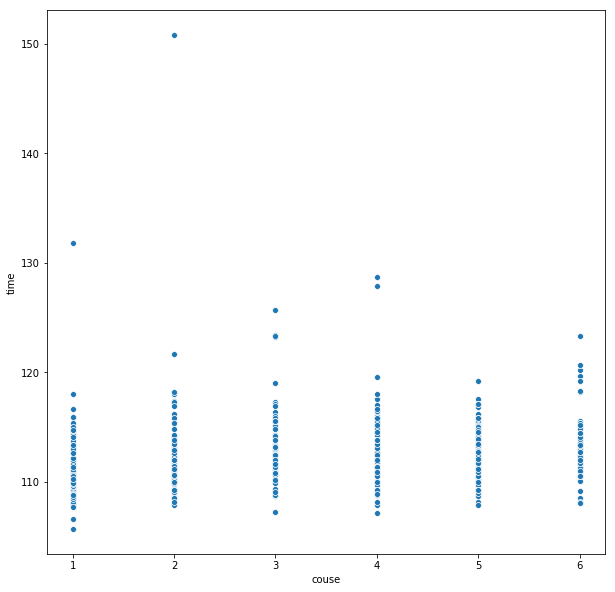

In [306]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x='couse', y='time', data=all_data[all_data.distance == 1800].sample(500))

# ここから前処理

### ここからレース毎の集計(train とtestを分ける前に行って問題ない集計処理)

In [307]:
all_data["month"] = all_data.deadline.dt.month

In [308]:
all_data["is_short_race"] = all_data.distance != 1800

In [309]:
couse_1_racer = all_data[all_data.couse == 1]
grouped_df = couse_1_racer.groupby(["race_id"]).racer_id.mean()
grouped_df.name = 'couse_1_racer_id'
all_data = pd.merge(all_data, grouped_df, on=["race_id"], how='left')

couse_racer = all_data[all_data.couse == 2]
grouped_df = couse_racer.groupby(["race_id"]).racer_id.mean()
grouped_df.name = 'couse_2_racer_id'
all_data = pd.merge(all_data, grouped_df, on=["race_id"], how='left')

couse_racer = all_data[all_data.couse == 3]
grouped_df = couse_racer.groupby(["race_id"]).racer_id.mean()
grouped_df.name = 'couse_3_racer_id'
all_data = pd.merge(all_data, grouped_df, on=["race_id"], how='left')

couse_racer = all_data[all_data.couse == 4]
grouped_df = couse_racer.groupby(["race_id"]).racer_id.mean()
grouped_df.name = 'couse_4_racer_id'
all_data = pd.merge(all_data, grouped_df, on=["race_id"], how='left')

couse_racer = all_data[all_data.couse == 5]
grouped_df = couse_racer.groupby(["race_id"]).racer_id.mean()
grouped_df.name = 'couse_5_racer_id'
all_data = pd.merge(all_data, grouped_df, on=["race_id"], how='left')

couse_racer = all_data[all_data.couse == 6]
grouped_df = couse_racer.groupby(["race_id"]).racer_id.mean()
grouped_df.name = 'couse_6_racer_id'
all_data = pd.merge(all_data, grouped_df, on=["race_id"], how='left')

In [310]:
couse_1_racer = all_data[all_data.couse == 1]
grouped_df = couse_1_racer.groupby(["race_id"]).win_rate.mean()
grouped_df.name = 'couse_1_win_rate'
all_data = pd.merge(all_data, grouped_df, on=["race_id"], how='left')

couse_1_racer = all_data[all_data.couse == 2]
grouped_df = couse_1_racer.groupby(["race_id"]).win_rate.mean()
grouped_df.name = 'couse_2_win_rate'
all_data = pd.merge(all_data, grouped_df, on=["race_id"], how='left')

couse_1_racer = all_data[all_data.couse == 3]
grouped_df = couse_1_racer.groupby(["race_id"]).win_rate.mean()
grouped_df.name = 'couse_3_win_rate'
all_data = pd.merge(all_data, grouped_df, on=["race_id"], how='left')

couse_1_racer = all_data[all_data.couse == 4]
grouped_df = couse_1_racer.groupby(["race_id"]).win_rate.mean()
grouped_df.name = 'couse_4_win_rate'
all_data = pd.merge(all_data, grouped_df, on=["race_id"], how='left')

couse_1_racer = all_data[all_data.couse == 5]
grouped_df = couse_1_racer.groupby(["race_id"]).win_rate.mean()
grouped_df.name = 'couse_5_win_rate'
all_data = pd.merge(all_data, grouped_df, on=["race_id"], how='left')

couse_1_racer = all_data[all_data.couse == 6]
grouped_df = couse_1_racer.groupby(["race_id"]).win_rate.mean()
grouped_df.name = 'couse_6_win_rate'
all_data = pd.merge(all_data, grouped_df, on=["race_id"], how='left')

In [311]:
all_train_data = all_data[(all_data.deadline < dt.datetime(2020,7,1))]
test_data = all_data[(dt.datetime(2020,7,1) <= all_data.deadline) & (all_data.deadline <= dt.datetime(2020,7,30))]

### 平均タイムとかの集計は、学習データのみでする必要がある

In [312]:
train_data , valid_data = train_test_split(all_train_data, random_state=0, test_size=0.2)

In [313]:
# moter_id
grouped_df = train_data.groupby(["moter_id"]).time.mean()
grouped_df.name = 'mean_time_by_moter_id'
train_data = pd.merge(train_data, grouped_df, on=["moter_id"])
valid_data = pd.merge(valid_data, grouped_df, on=["moter_id"])
test_data= pd.merge(test_data, grouped_df, on=["moter_id"])

In [314]:
# 場所、コース毎の順位
grouped_df = train_data.groupby(["couse","place"]).prize.mean()
grouped_df.name = 'mean_prize_by_couse_place'
train_data = pd.merge(train_data, grouped_df, on=["couse","place"])
valid_data = pd.merge(valid_data, grouped_df, on=["couse","place"])
test_data= pd.merge(test_data, grouped_df, on=["couse","place"])

In [315]:
# 場所、コース毎の順位
grouped_df = train_data.groupby(["couse","place"]).prize.median()
grouped_df.name = 'median_prize_by_couse_place'
train_data = pd.merge(train_data, grouped_df, on=["couse","place"])
valid_data = pd.merge(valid_data, grouped_df, on=["couse","place"])
test_data= pd.merge(test_data, grouped_df, on=["couse","place"])

In [316]:
# moter_id
grouped_df = train_data.groupby(["moter_id"]).prize.mean()
grouped_df.name = 'mean_prize_by_moter_id'
train_data = pd.merge(train_data, grouped_df, on=["moter_id"])
valid_data = pd.merge(valid_data, grouped_df, on=["moter_id"])
test_data= pd.merge(test_data, grouped_df, on=["moter_id"])

In [317]:
# moter_id
grouped_df = train_data.groupby(["moter_id"]).prize.median()
grouped_df.name = 'median_prize_by_moter_id'
train_data = pd.merge(train_data, grouped_df, on=["moter_id"])
valid_data = pd.merge(valid_data, grouped_df, on=["moter_id"])
test_data= pd.merge(test_data, grouped_df, on=["moter_id"])

In [318]:
# 場所、コース毎のタイム(1800mのみ)
grouped_df = train_data[train_data.distance == 1800].groupby(["couse","place"]).time.mean()
grouped_df.name = 'mean_time_by_couse_place'
train_data = pd.merge(train_data, grouped_df, on=["couse","place"])
valid_data = pd.merge(valid_data, grouped_df, on=["couse","place"])
test_data= pd.merge(test_data, grouped_df, on=["couse","place"])

In [319]:
# 場所、コース毎のタイム(1800mのみ)
grouped_df = train_data[train_data.distance == 1800].groupby(["couse","place"]).time.median()
grouped_df.name = 'median_time_by_couse_place'
train_data = pd.merge(train_data, grouped_df, on=["couse","place"])
valid_data = pd.merge(valid_data, grouped_df, on=["couse","place"])
test_data= pd.merge(test_data, grouped_df, on=["couse","place"])

In [320]:
# 場所、コース毎のタイム(1800mのみ)
grouped_df = train_data[train_data.distance == 1800].groupby(["place"]).time.median()
grouped_df.name = 'median_time_by_place'
train_data = pd.merge(train_data, grouped_df, on=["place"])
valid_data = pd.merge(valid_data, grouped_df, on=["place"])
test_data= pd.merge(test_data, grouped_df, on=["place"])

grouped_df = train_data[train_data.distance == 1800].groupby(["place"]).time.mean()
grouped_df.name = 'mean_time_by_place'
train_data = pd.merge(train_data, grouped_df, on=["place"])
valid_data = pd.merge(valid_data, grouped_df, on=["place"])
test_data= pd.merge(test_data, grouped_df, on=["place"])

## ここから機械学習

In [321]:
# 2020/07のレース結果を予測する
# 利用するデータは2020/06までのもの

In [390]:
cols = [
    "place",
    "race_number",
#     "distance",
    "couse",
    "age",
    "weight",
    "rank",
    "win_rate",
    "exacta_rate",
    "win_rate_place",
    "exacta_race_place",
    "moter_id",
    "exacta_race_mortor",
    "boat_id",
    "exacta_race_boat",
    "exhibition_time",
    "tilt",
    "month",
    "mean_time_by_place",
    "median_time_by_place",
    'mean_time_by_couse_place',
    "median_time_by_couse_place",
    "racer_id",
    'couse_1_racer_id',
    'couse_2_racer_id',
    'couse_3_racer_id',
    'couse_4_racer_id',
    'couse_5_racer_id',
    'couse_6_racer_id',
    'mean_prize_by_couse_place',
    'median_prize_by_couse_place',
#     'mean_prize_by_moter_id',
#     'median_prize_by_moter_id',
#     'couse_1_win_rate',
#     'couse_2_win_rate',
#     'couse_3_win_rate',
#     'couse_4_win_rate',
#     'couse_5_win_rate',
#     'couse_6_win_rate',
#     'mean_time_by_moter_id',
#     "mean_time_by_couse"
#     "is_short_race"
]
len(cols)

30

In [391]:
train_dataset = lgb.Dataset(train_data[cols], train_data["prize"])
valid_dataset = lgb.Dataset(valid_data[cols], valid_data["prize"])

In [392]:
params = {'bagging_fraction': 0.9898106657338858,
 'bagging_freq': 1,
 'feature_fraction': 0.8,
 'feature_pre_filter': False,
 'lambda_l1': 8.559554598335243,
 'lambda_l2': 1.9907443721757583,
 'metric': 'rmse',
 'min_child_samples': 20,
 'min_data_in_leaf': 20,
 'num_leaves': 26,
 'objective': 'regression',
 'random_seed': 0}

In [393]:
# tuner = optlgb.LightGBMTunerCV(tuner.best_params, train_dataset,
#                             num_boost_round=10000,
#                             verbose_eval=1000, early_stopping_rounds=100, folds=KFold(n_splits=5))

# ハイパーパラメータ探索の実行
# tuner.run()

In [394]:
# tuner.best_params

In [395]:
lbgm = lgb.train(params, train_dataset, valid_sets=[valid_dataset],
                num_boost_round=10000, early_stopping_rounds=10, verbose_eval=1000)

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[159]	valid_0's rmse: 1.13527


In [396]:
lbgm.best_score['valid_0']['rmse']

1.1352686695679426

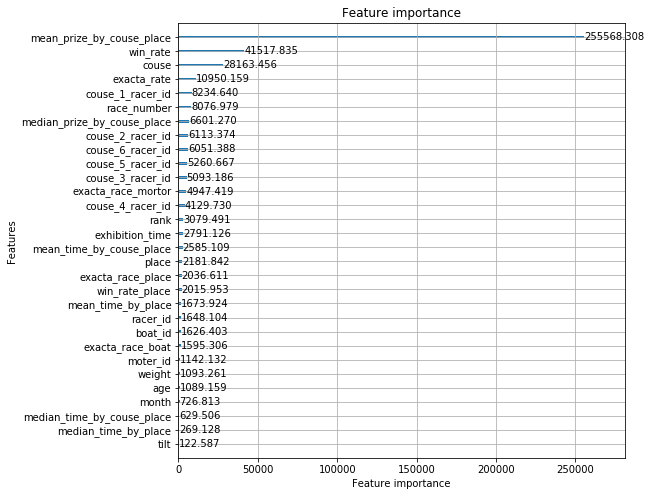

In [397]:
lgb.plot_importance(lbgm, importance_type='gain', figsize=(8, 8))

# ここから予測結果のスコア計算

In [404]:
pred = lbgm.predict(test_data[cols])
df_pred = test_data[["race_id", "distance", "couse", "prize", "time"]]
df_pred["pred_prize"] = pred

# 一位予想
pred_first_prize = df_pred.groupby(["race_id"]).pred_prize.min()
pred_first_prize = pred_first_prize.rename("pred_1st_prize")
df_pred = pd.merge(df_pred, pred_first_prize, on="race_id")
df_pred["is_1st_pred"] = (df_pred.pred_prize == df_pred.pred_1st_prize)

# 二位予想
pred_second_prize = df_pred.loc[df_pred.is_1st_pred == False].groupby(["race_id"]).pred_prize.min()
pred_second_prize = pred_second_prize.rename("pred_2nd_prize")
df_pred = pd.merge(df_pred, pred_second_prize, on="race_id")
df_pred["is_2nd_pred"] = (df_pred.pred_prize == df_pred.pred_2nd_prize)

# 3位予想
pred_second_prize = df_pred.loc[(df_pred.is_1st_pred == False) & (df_pred.is_2nd_pred == False)].groupby(["race_id"]).pred_prize.min()
pred_second_prize = pred_second_prize.rename("pred_3rd_prize")
df_pred = pd.merge(df_pred, pred_second_prize, on="race_id")
df_pred["is_3rd_pred"] = (df_pred.pred_prize == df_pred.pred_3rd_prize)

df_pred["is_1st"] = (df_pred.prize == 1.0)
df_pred["is_2nd"] = (df_pred.prize == 2.0)
df_pred["is_3rd"] = (df_pred.prize == 3.0)


/Users/kobayashiyouta/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [405]:
confusion_matrix(df_pred.is_1st, df_pred.is_1st_pred)

array([[13629,  1734],
       [ 1734,  2590]])

In [406]:
confusion_matrix(df_pred.is_2nd, df_pred.is_2nd_pred)

array([[12497,  2866],
       [ 2866,  1458]])

In [407]:
confusion_matrix(df_pred.is_3rd, df_pred.is_3rd_pred)

array([[12313,  3048],
       [ 3050,  1276]])

In [409]:
set_1st = set(df_pred[(df_pred.is_1st == True) & (df_pred.is_1st_pred == True)].race_id.unique())
set_2nd = set(df_pred[(df_pred.is_2nd == True) & (df_pred.is_2nd_pred == True)].race_id.unique())
len(set_1st & set_2nd)

1215

In [410]:
set_1st = set(df_pred[(df_pred.is_1st == True) & (df_pred.is_1st_pred == True)].race_id.unique())
set_2nd = set(df_pred[(df_pred.is_2nd == True) & (df_pred.is_2nd_pred == True)].race_id.unique())
set_3rd = set(df_pred[(df_pred.is_3rd == True) & (df_pred.is_3rd_pred == True)].race_id.unique())
len(set_1st & set_2nd & set_3rd)

661

In [402]:
with open('result.txt', 'a') as f:
  f.write(f"{[params, cols, lbgm.best_score['valid_0']['rmse'], len(set_1st), len(set_2nd), len(set_1st & set_2nd)]} \n")

In [403]:
len(df_pred.race_id.unique())

4327